## Initialize all imports

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import conda_installer
from rdkit import Chem
from deepchem.feat.graph_features import atom_features as get_atom_features
import rdkit
import pickle
import copy
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


import importlib
import keras.backend as K
# import tensorflow_addons as tfa
from tensorflow.keras import regularizers, constraints, callbacks

import sys
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam


2025-05-01 23:58:45.778199: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-01 23:58:45.845689: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normaliz

## Read Input data & Change directory

In [2]:
PDBs = pickle.load(open('Datasets/PDBs_RDKit_BFE.pkl', 'rb'))
df = pd.read_csv('Datasets/Final_data_DDG.csv')


In [3]:

import models.layers_update_mobley as layers
from models.dcFeaturizer import atom_features as get_atom_features
importlib.reload(layers)
from models.PGCN_model_multiloss import get_trained_model, test_model

## Data pre-processing

In [4]:
info = []
for pdb in list(PDBs.keys()):
    info.append(df[df['Ids'] == pdb][['pb_host_VDWAALS', 'pb_guest_VDWAALS', 'pb_complex_VDWAALS', 'gb_host_1-4EEL', 'gb_guest_1-4EEL', 'gb_Complex_1-4EEL',
       'gb_host_EELEC', 'gb_guest_EELEC', 'gb_Complex_EELEC', 'gb_host_EGB', 'gb_guest_EGB', 'gb_Complex_EGB', 'gb_host_ESURF', 'gb_guest_ESURF', 'gb_Complex_ESURF']].to_numpy()[0])

In [5]:
def featurize(molecule, info):
    
    atom_features = []
    for atom in molecule.GetAtoms():
        new_feature = get_atom_features(atom).tolist()
        position = molecule.GetConformer().GetAtomPosition(atom.GetIdx())
        new_feature += [atom.GetMass(), atom.GetAtomicNum(),atom.GetFormalCharge()]
        new_feature += [position.x, position.y, position.z]
        for neighbor in atom.GetNeighbors()[:2]:
            neighbor_idx = neighbor.GetIdx()
            new_feature += [neighbor_idx]
        for i in range(2 - len(atom.GetNeighbors())):
            new_feature += [-1]

        atom_features.append(np.concatenate([new_feature, info], 0))
    return np.array(atom_features)

In [6]:
X = []
y = []
for i, pdb in enumerate(list(PDBs.keys())):
    X.append(featurize(PDBs[pdb], info[i]))
    y.append(df[df['Ids'] == pdb]['Ex _G_(kcal/mol)'].to_numpy()[0])


In [7]:
# Split the data into training and testing sets
# Randomly shuffles the data before splitting, ensuring that the training and testing sets are representative of the overall dataset.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
len(X_train), len(X_test), len(y_train), len(y_test)

(57, 15, 57, 15)

## Helper Functions

In [9]:

class PGGCN_Hybrid(tf.keras.Model):
    def __init__(self, num_atom_features=36, r_out_channel=20, c_out_channel=128, l2=1e-4, dropout_rate=0.2, maxnorm=3.0):
        super().__init__()
        self.ruleGraphConvLayer = layers.RuleGraphConvLayer(r_out_channel, num_atom_features, 0)
        self.ruleGraphConvLayer.combination_rules = []
        self.conv = layers.ConvLayer(c_out_channel, r_out_channel)
        self.dense1 = tf.keras.layers.Dense(32, activation='relu', name='dense1', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dense5 = tf.keras.layers.Dense(16, activation='relu', name='dense2', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.dense6 = tf.keras.layers.Dense(1, name='dense6', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dense7 = tf.keras.layers.Dense(1, name='dense7',
                                             kernel_initializer=tf.keras.initializers.Constant([.3, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1]),
                                             bias_initializer=tf.keras.initializers.Zeros(),
                                             kernel_regularizer=regularizers.l2(l2), 
                                             bias_regularizer=regularizers.l2(l2), 
                                             kernel_constraint=constraints.MaxNorm(maxnorm))

    def addRule(self, rule, start_index, end_index=None):
        self.ruleGraphConvLayer.addRule(rule, start_index, end_index)
        
    def set_input_shapes(self, i_s):
        self.i_s = i_s

    def call(self, inputs, training=True):
        print("Inside call")
        physics_info = inputs[:, 0, 38:] 
        x_a = []
        for i in range(len(self.i_s)):
            x_a.append(inputs[i][:self.i_s[i], :38])
        x = self.ruleGraphConvLayer(x_a)
        x = self.conv(x)
        x = self.dense1(x)
        x = self.dropout1(x, training=training)
        x = self.dense5(x)
        x = self.dropout2(x, training=training)
        model_var = self.dense6(x)
        merged = tf.concat([model_var, physics_info], axis=1)
        out = self.dense7(merged)
        return tf.concat([out, physics_info], axis=1)
    
empirical_loss_value = tf.Variable(0.0, trainable=False, dtype=tf.float32)
physics_loss_value = tf.Variable(0.0, trainable=False, dtype=tf.float32)
   
class LossComponentsCallback_Hybrid(tf.keras.callbacks.Callback):
    def __init__(self,model_instance):
        super().__init__()
        self.empirical_losses = []
        self.physical_losses = []
        self.total_losses = []
        self.learning_rates = []
        self.model = model_instance
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        lr = self.model.optimizer.learning_rate
        self.total_losses.append(logs.get('loss'))
        self.empirical_losses.append(float(empirical_loss_value.numpy()))
        self.physical_losses.append(float(physics_loss_value.numpy()))
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model.optimizer.iterations)  # Call the schedule
        else:
            lr = lr  

        self.learning_rates.append(float(tf.keras.backend.get_value(lr)))


def pure_rmse_hybrid(y_true, y_pred):
    y_true_flat = tf.reshape(y_true, [-1])
    return K.sqrt(K.mean(K.square(y_pred - y_true_flat)))

def physical_consistency_loss(y_true,y_pred,physics_info):
    dG_pred = y_pred
    y_true = tf.reshape(y_true, (-1, 1))

    # Physical Inconsistency loss
    # Extract the components from physics_info
    host = tf.gather(physics_info, [0, 3, 6, 9, 12], axis=1)  # Host energy terms
    guest = tf.gather(physics_info, [1, 4, 7, 10, 13], axis=1)  # Guest energy terms
    complex_ = tf.gather(physics_info, [2, 5, 8, 11, 14], axis=1)  # Complex energy terms

    # Calculate ΔG based on physics: ΔG = ΔGcomplex - (ΔGhost + ΔGguest)
    dG_physics = tf.reduce_sum(complex_, axis=1, keepdims=True) - (tf.reduce_sum(host, axis=1, keepdims=True) + tf.reduce_sum(guest, axis=1, keepdims=True))
    phy_loss = K.sqrt(K.mean(K.square(dG_pred - dG_physics)))
    

    return phy_loss



def combined_loss(physics_hyperparam=0.0003):
    
    def loss_function(y_true, y_pred):
        # Extract prediction and physics info
        prediction = y_pred[:, 0]
        physics_info = y_pred[:, 1:16]  # Assuming 15 physical features
        
        # Calculate individual loss components
        empirical_loss = pure_rmse_hybrid(y_true, prediction)
        physics_loss = physical_consistency_loss(y_true, prediction, physics_info)

        total_loss = empirical_loss + (physics_hyperparam * physics_loss)
        empirical_loss_value.assign(empirical_loss)
        physics_loss_value.assign(physics_loss) 

        return total_loss
    
    return loss_function






2025-05-01 23:58:55.165949: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-05-01 23:58:55.165980: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (curie.cluster): /proc/driver/nvidia/version does not exist
2025-05-01 23:58:55.166740: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


---------- Hyperparameter combinations ------------
Epoch : 250;  physics_weight: 0.005;
Epoch 1/250
Inside call
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Inside call
1/1 [==============================] - 52s 52s/step - loss: 9.0942
Epoch 2/250
1/1 [==============================] - 1s 553ms/step - loss: 16.4616
Epoch 3/250
1/1 [==============================] - 1s 802ms/step - loss: 7.8610
Epoch 4/250
1/1 [==============================] - 1s 781ms/step - loss: 10.8587
Epoch 5/250
1/1 [==============================] - 1s 833ms/step - loss: 12.2373
Epoch 6/250
1/1 [==============================] - 1s 790ms/step - loss: 8.0422
Epoch 7/250
1/1 [==============================] - 1s 805ms/step - loss: 4.0344
Epoch 8/250
1/1 [==============================] - 1s 815ms/step - loss: 7.6830
Epoch 9/250
1/1 [===========================

1/1 [==============================] - 1s 828ms/step - loss: 2.4843
Epoch 95/250
1/1 [==============================] - 1s 818ms/step - loss: 2.4810
Epoch 96/250
1/1 [==============================] - 1s 829ms/step - loss: 2.4762
Epoch 97/250
1/1 [==============================] - 1s 859ms/step - loss: 2.4723
Epoch 98/250
1/1 [==============================] - 1s 838ms/step - loss: 2.4682
Epoch 99/250
1/1 [==============================] - 1s 795ms/step - loss: 2.4639
Epoch 100/250
1/1 [==============================] - 1s 786ms/step - loss: 2.4602
Epoch 101/250
1/1 [==============================] - 1s 857ms/step - loss: 2.4558
Epoch 102/250
1/1 [==============================] - 1s 858ms/step - loss: 2.4520
Epoch 103/250
1/1 [==============================] - 1s 772ms/step - loss: 2.4479
Epoch 104/250
1/1 [==============================] - 1s 822ms/step - loss: 2.4439
Epoch 105/250
1/1 [==============================] - 1s 768ms/step - loss: 2.4400
Epoch 106/250
1/1 [================

1/1 [==============================] - 1s 823ms/step - loss: 2.1693
Epoch 195/250
1/1 [==============================] - 1s 801ms/step - loss: 2.1671
Epoch 196/250
1/1 [==============================] - 1s 768ms/step - loss: 2.1649
Epoch 197/250
1/1 [==============================] - 1s 783ms/step - loss: 2.1627
Epoch 198/250
1/1 [==============================] - 1s 743ms/step - loss: 2.1604
Epoch 199/250
1/1 [==============================] - 1s 773ms/step - loss: 2.1583
Epoch 200/250
1/1 [==============================] - 1s 776ms/step - loss: 2.1561
Epoch 201/250
1/1 [==============================] - 1s 761ms/step - loss: 2.1539
Epoch 202/250
1/1 [==============================] - 1s 765ms/step - loss: 2.1518
Epoch 203/250
1/1 [==============================] - 1s 753ms/step - loss: 2.1497
Epoch 204/250
1/1 [==============================] - 1s 801ms/step - loss: 2.1476
Epoch 205/250
1/1 [==============================] - 1s 790ms/step - loss: 2.1455
Epoch 206/250
1/1 [===========

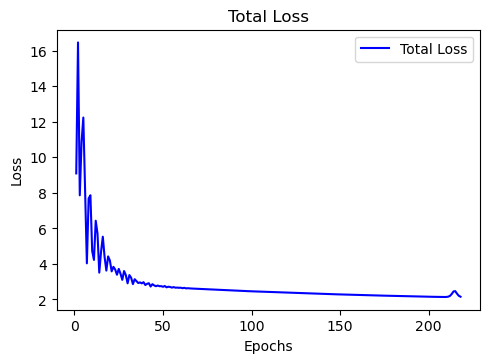

In [10]:
import csv

physics_hyperparam = [0.005]
epochs = [250]
lr_schedule = ExponentialDecay(
        initial_learning_rate=0.005,
        decay_steps=10000,
        decay_rate=0.9,
        staircase=True
    )
results = {}
y_differences = []
total_losses = []
empirical_losses = []
physics_losses = []
all_results=[]
    
for epoch in epochs:
        for physics_weight in physics_hyperparam:
            print("---------- Hyperparameter combinations ------------")
            print("Epoch : {};  physics_weight: {};".format(str(epoch),  str(physics_weight)))

            m = PGGCN_Hybrid()
            m.addRule("sum", 0, 32)
            m.addRule("multiply", 32, 33)
            m.addRule("distance", 33, 36)

            opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
            m.compile(loss=combined_loss(physics_weight), optimizer=opt)

            input_shapes = []
            for i in range(len(X_train)):
                input_shapes.append(np.array(X_train[i]).shape[0])
            m.set_input_shapes(input_shapes)
            for i in range(len(X_train)):
                if X_train[i].shape[0] < 2000:
                    new_list = np.zeros([2000 - X_train[i].shape[0], 53])
                    X_train[i] = np.concatenate([X_train[i], new_list], 0)
            X_train = np.array(X_train)
            y_train = np.array(y_train)
            

            loss_tracker = LossComponentsCallback_Hybrid(m)

            # Add early stopping
            early_stopping = EarlyStopping(
                monitor='loss',           
                patience=10,              
                restore_best_weights=True, 
                min_delta=0.001,          
                verbose=1                 
            )

            hist = m.fit(X_train, y_train, epochs = epoch, batch_size=len(X_train),callbacks=[loss_tracker,early_stopping])


            input_shapes = []
            for i in range(len(X_test)):
                input_shapes.append(np.array(X_test[i]).shape[0])
            m.set_input_shapes(input_shapes)

            for i in range(len(X_test)):
                if X_test[i].shape[0] < 2000:
                    new_list = np.zeros([2000 - X_test[i].shape[0], 53])
                    X_test[i] = np.concatenate([X_test[i], new_list], 0)
            X_test = np.array(X_test)
            x_c = copy.deepcopy(X_test)
            y_test = np.array(y_test)
            y_pred_test = m.predict(X_test)
            y_pred_test = np.array(y_pred_test[:,0])

            y_difference = np.mean(np.abs(np.abs(y_test) - np.abs(y_pred_test)))
            eval = m.evaluate(X_test, y_test)
            print("The mean absolute difference between y_tru & y_pred is : {}" .format(str(y_difference)))

            final_train_loss = loss_tracker.total_losses[-1] if loss_tracker.total_losses else None
            
            result_temp = {
                'name':'ΔΔG with Multi-Loss',
                'y_test': y_test,
                'test_loss': eval,
                'y_pred_test': y_pred_test,
                'MAD': y_difference,
                'all_losses': loss_tracker.total_losses,
                'empirical_losses': loss_tracker.empirical_losses if hasattr(loss_tracker, 'empirical_losses') else None,
                'physical_losses': loss_tracker.physical_losses if hasattr(loss_tracker, 'physical_losses') else None,
                'hyperparameters': {
                                    'physics_weight': physics_weight,
                                    'epochs': epoch,
                                    'initial_learning_rate': 0.005,
                                    'decay_steps': 10000,
                                    'decay_rate': 0.9
                }
            }

            
            # Also append to the all_results list for combined saving later
            results["multi_loss_run"] = result_temp
            all_results.append(result_temp)
        

        # Plot all loss components over epochs
        plt.figure(figsize=(12, 8))

        epoch_length = range(1, len(loss_tracker.total_losses) + 1)

        # Total loss
        plt.subplot(2, 2, 1)
        plt.plot(epoch_length, loss_tracker.total_losses, 'b-', label='Total Loss')
        plt.title('Total Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()


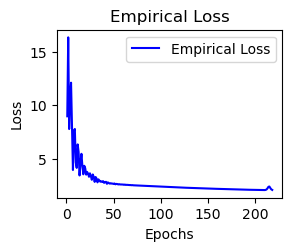

In [11]:
plt.subplot(2, 2, 1)
plt.plot(epoch_length, loss_tracker.empirical_losses, 'b-', label='Empirical Loss')
plt.title('Empirical Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [12]:
hybrid_y_true = y_test
hybrid_y_pred = y_pred_test

In [13]:
print(hybrid_y_true)
print(hybrid_y_pred)

[3.597 4.97  2.13  2.022 3.394 4.52  1.506 1.458 2.51  5.04  3.72  1.554
 1.575 4.73  3.344]
[ 6.458768    6.9718294   2.6680577   1.5049107   3.5718663   9.448636
  0.14510843  2.8168004   4.836087    5.202359    5.7796297  -1.4687221
 -0.97476465  5.6543856   0.19833109]


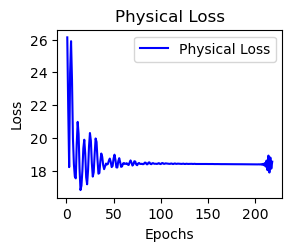

In [14]:
plt.subplot(2, 2, 1)
plt.plot(epoch_length, loss_tracker.physical_losses, 'b-', label='Physical Loss')
plt.title('Physical Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

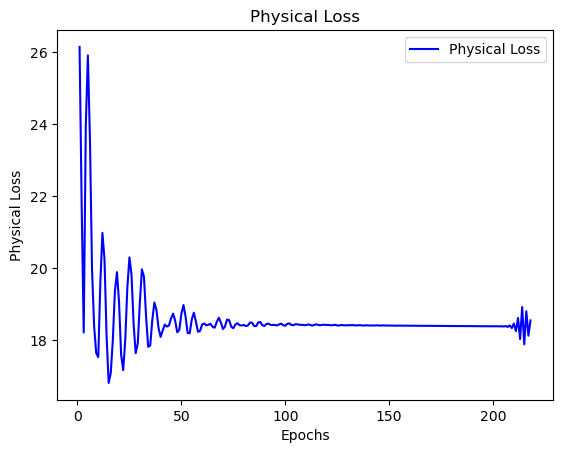

In [15]:


# hist is the History object returned by .fit()
plt.plot(epoch_length, loss_tracker.physical_losses, 'b-', label='Physical Loss')
plt.title('Physical Loss')

plt.xlabel('Epochs')
plt.ylabel('Physical Loss')
plt.legend()
plt.show()

In [16]:
print(len(loss_tracker.empirical_losses))
print(len(loss_tracker.physical_losses))

218
218


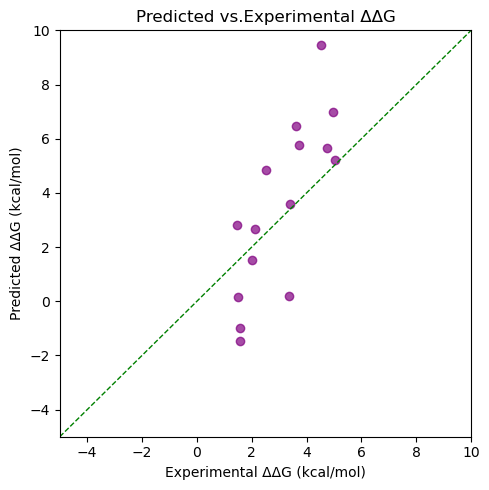

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.title("Predicted vs.Experimental ΔΔG")
plt.scatter(y_test, y_pred_test, alpha=0.7, color="purple")
plt.xlabel("Experimental ΔΔG (kcal/mol)")
plt.ylabel("Predicted ΔΔG (kcal/mol)")
plt.xlim(-5,10)
plt.ylim(-5, 10)

# Reference y = x line
plt.plot([-5, 10], [-5, 10], color='green', lw=1, linestyle='--')
plt.tight_layout()
plt.savefig('Model_Performance_Predicted_vs_Experimental_DDG.png',dpi=100, bbox_inches='tight')
plt.show()

## BFE WITHOUT LOSS

In [18]:
info = []
for pdb in list(PDBs.keys()):
    info.append(df[df['Ids'] == pdb][['pb_host_VDWAALS', 'pb_guest_VDWAALS', 'pb_complex_VDWAALS', 'gb_host_1-4EEL', 'gb_guest_1-4EEL', 'gb_Complex_1-4EEL',
       'gb_host_EELEC', 'gb_guest_EELEC', 'gb_Complex_EELEC', 'gb_host_EGB', 'gb_guest_EGB', 'gb_Complex_EGB', 'gb_host_ESURF', 'gb_guest_ESURF', 'gb_Complex_ESURF']].to_numpy()[0])


In [19]:
X = []
y = []
for i, pdb in enumerate(list(PDBs.keys())):
    X.append(featurize(PDBs[pdb], info[i]))
    y.append(df[df['Ids'] == pdb]['Ex _G_(kcal/mol)'].to_numpy()[0])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
len(X_train), len(X_test), len(y_train), len(y_test)

(57, 15, 57, 15)

In [21]:
import models.layers_update_mobley as layers
import importlib
importlib.reload(layers)
import keras.backend as K

from tensorflow.keras.callbacks import EarlyStopping

class PGGCNModel(tf.keras.Model):
    def __init__(self, num_atom_features = 36, r_out_channel = 20, c_out_channel = 128):
        super().__init__()
        self.ruleGraphConvLayer = layers.RuleGraphConvLayer(r_out_channel, num_atom_features, 0)
        self.ruleGraphConvLayer.combination_rules = []
        self.conv = layers.ConvLayer(c_out_channel)
        self.dense1 = tf.keras.layers.Dense(32, activation='relu', name='dense1')
        self.dense5 = tf.keras.layers.Dense(16, name='relu')
        self.dense6 = tf.keras.layers.Dense(1, name='dense6')
        self.dense7 = tf.keras.layers.Dense(1, name='dense7',
                 kernel_initializer=tf.keras.initializers.Constant([.3, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1]),
                 bias_initializer=tf.keras.initializers.Zeros())
        self.all_layer_1_weights = []
        
    def addRule(self, rule, start_index, end_index = None):
        self.ruleGraphConvLayer.addRule(rule, start_index, end_index)
    
    def set_input_shapes(self, i_s):
        self.i_s = i_s

    def call(self, inputs):
        physics_info = inputs[:,0,38:]
        x_a = []
        for i in range(len(self.i_s)):
            x_a.append(inputs[i][:self.i_s[i], :38])
        x = self.ruleGraphConvLayer(x_a)
        self.all_layer_1_weights.append(self.ruleGraphConvLayer.w_s)
        x = self.conv(x)
        x = self.dense1(x)
        x = self.dense5(x)
        model_var = self.dense6(x)
        merged = tf.concat([model_var, physics_info], axis=1)
        out = self.dense7(merged)
        return out
       
class LossComponentsCallback(tf.keras.callbacks.Callback):
    def __init__(self,model_instance):
        super().__init__()
        self.total_losses = []
        self.model = model_instance
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        lr = self.model.optimizer.learning_rate
        self.total_losses.append(logs.get('loss'))

        
def pure_rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


mn= PGGCNModel()
mn.addRule("sum", 0, 32)
mn.addRule("multiply", 32, 33)
mn.addRule("distance", 33, 36)



opt = tf.keras.optimizers.Adam(learning_rate=0.005)
mn.compile(loss=pure_rmse, optimizer=opt)


input_shapes = []
for i in range(len(X_train)):
    input_shapes.append(np.array(X_train[i]).shape[0])
mn.set_input_shapes(input_shapes)
for i in range(len(X_train)):
    if X_train[i].shape[0] < 2000:
        new_list = np.zeros([2000 - X_train[i].shape[0], 53])
        X_train[i] = np.concatenate([X_train[i], new_list], 0)
        
X_train_nohyb = np.array(X_train)
y_train_nohyb = np.array(y_train)

loss_tracker_nohyb = LossComponentsCallback(mn)

early_stop = EarlyStopping(
monitor='loss',           
patience=15,              
restore_best_weights=True, 
min_delta=0.001,          
verbose=1                 
)
hist = mn.fit(X_train_nohyb, y_train_nohyb, epochs = 400, batch_size=len(X_train_nohyb), callbacks=[early_stop,loss_tracker_nohyb])


Epoch 1/400
1/1 [==============================] - 53s 53s/step - loss: 8.9546
Epoch 2/400
1/1 [==============================] - 1s 747ms/step - loss: 20.5026
Epoch 3/400
1/1 [==============================] - 1s 650ms/step - loss: 11.6362
Epoch 4/400
1/1 [==============================] - 1s 676ms/step - loss: 9.5794
Epoch 5/400
1/1 [==============================] - 1s 647ms/step - loss: 12.6878
Epoch 6/400
1/1 [==============================] - 1s 642ms/step - loss: 10.5572
Epoch 7/400
1/1 [==============================] - 1s 654ms/step - loss: 5.7984
Epoch 8/400
1/1 [==============================] - 1s 760ms/step - loss: 7.4526
Epoch 9/400
1/1 [==============================] - 1s 747ms/step - loss: 9.6825
Epoch 10/400
1/1 [==============================] - 1s 826ms/step - loss: 8.2208
Epoch 11/400
1/1 [==============================] - 1s 722ms/step - loss: 4.7497
Epoch 12/400
1/1 [==============================] - 1s 733ms/step - loss: 5.8436
Epoch 13/400
1/1 [================

1/1 [==============================] - 1s 759ms/step - loss: 3.4184
Epoch 103/400
1/1 [==============================] - 1s 799ms/step - loss: 3.4158
Epoch 104/400
1/1 [==============================] - 1s 796ms/step - loss: 3.4131
Epoch 105/400
1/1 [==============================] - 1s 783ms/step - loss: 3.4101
Epoch 106/400
1/1 [==============================] - 1s 790ms/step - loss: 3.4079
Epoch 107/400
1/1 [==============================] - 1s 863ms/step - loss: 3.4048
Epoch 108/400
1/1 [==============================] - 1s 824ms/step - loss: 3.4024
Epoch 109/400
1/1 [==============================] - 1s 802ms/step - loss: 3.3996
Epoch 110/400
1/1 [==============================] - 1s 737ms/step - loss: 3.3970
Epoch 111/400
1/1 [==============================] - 1s 817ms/step - loss: 3.3944
Epoch 112/400
1/1 [==============================] - 1s 790ms/step - loss: 3.3918
Epoch 113/400
1/1 [==============================] - 1s 658ms/step - loss: 3.3891
Epoch 114/400
1/1 [===========

1/1 [==============================] - 1s 813ms/step - loss: 3.1953
Epoch 203/400
1/1 [==============================] - 1s 800ms/step - loss: 3.1934
Epoch 204/400
1/1 [==============================] - 1s 794ms/step - loss: 3.1916
Epoch 205/400
1/1 [==============================] - 1s 799ms/step - loss: 3.1897
Epoch 206/400
1/1 [==============================] - 1s 781ms/step - loss: 3.1879
Epoch 207/400
1/1 [==============================] - 1s 765ms/step - loss: 3.1861
Epoch 208/400
1/1 [==============================] - 1s 789ms/step - loss: 3.1844
Epoch 209/400
1/1 [==============================] - 1s 761ms/step - loss: 3.1826
Epoch 210/400
1/1 [==============================] - 1s 789ms/step - loss: 3.1807
Epoch 211/400
1/1 [==============================] - 1s 777ms/step - loss: 3.1790
Epoch 212/400
1/1 [==============================] - 1s 764ms/step - loss: 3.1772
Epoch 213/400
1/1 [==============================] - 1s 763ms/step - loss: 3.1754
Epoch 214/400
1/1 [===========

1/1 [==============================] - 1s 801ms/step - loss: 3.0345
Epoch 303/400
1/1 [==============================] - 1s 791ms/step - loss: 3.0331
Epoch 304/400
1/1 [==============================] - 1s 781ms/step - loss: 3.0317
Epoch 305/400
1/1 [==============================] - 1s 788ms/step - loss: 3.0303
Epoch 306/400
1/1 [==============================] - 1s 750ms/step - loss: 3.0290
Epoch 307/400
1/1 [==============================] - 1s 782ms/step - loss: 3.0276
Epoch 308/400
1/1 [==============================] - 1s 776ms/step - loss: 3.0262
Epoch 309/400
1/1 [==============================] - 1s 800ms/step - loss: 3.0248
Epoch 310/400
1/1 [==============================] - 1s 797ms/step - loss: 3.0235
Epoch 311/400
1/1 [==============================] - 1s 764ms/step - loss: 3.0221
Epoch 312/400
1/1 [==============================] - 1s 760ms/step - loss: 3.0208
Epoch 313/400
1/1 [==============================] - 1s 795ms/step - loss: 3.0195
Epoch 314/400
1/1 [===========

In [22]:
X_test_nohyb = X_test
y_test_nohyb = y_test
input_shapes = []
for i in range(len(X_test_nohyb)):
    input_shapes.append(np.array(X_test_nohyb[i]).shape[0])
mn.set_input_shapes(input_shapes)

for i in range(len(X_test_nohyb)):
    if X_test_nohyb[i].shape[0] < 2000:
        new_list = np.zeros([2000 - X_test[i].shape[0], 53])
        X_test_nohyb[i] = np.concatenate([X_test_nohyb[i], new_list], 0)
X_test_nohyb = np.array(X_test_nohyb)
x_c = copy.deepcopy(X_test_nohyb)
y_test_nohyb = np.array(y_test_nohyb)
y_pred_test_nohyb = mn.predict(X_test_nohyb) 
y_pred_test_nohyb = np.array(y_pred_test_nohyb)

y_difference_nohyb = np.mean(np.abs(np.abs(y_test_nohyb) - np.abs(y_pred_test_nohyb)))
eval_nohyb = mn.evaluate(X_test_nohyb, y_test_nohyb)
print("The mean absolute difference between y_tru & y_pred is : {}" .format(str(y_difference_nohyb)))


result_temp = {
    'name':'ΔΔG with Traditional RMSE',
    'y_test': y_test_nohyb,
    'test_loss': eval_nohyb,
    'y_pred_test': y_pred_test_nohyb,
    'MAD': y_difference_nohyb,
    'all_losses': loss_tracker_nohyb.total_losses,
    'empirical_losses': None,
    'physical_losses': None,
    'hyperparameters': {
                        'physics_weight': None,
                        'epochs': None,
                        'initial_learning_rate': None,
                        'decay_steps': None,
                        'decay_rate': None
    }
}


# Also append to the all_results list for combined saving later
results["traditional loss"] = result_temp
all_results.append(result_temp)

1/1 [==============================] - 5s 5s/step - loss: 3.4123
The mean absolute difference between y_tru & y_pred is : 2.834921977208456


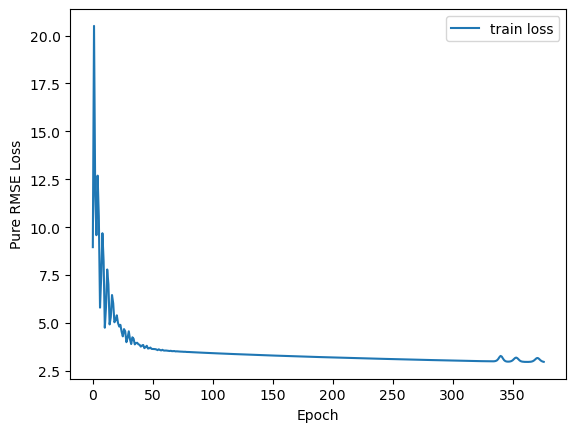

In [23]:
import matplotlib.pyplot as plt

# hist is the History object returned by .fit()
plt.plot(hist.history['loss'], label='train loss')

plt.xlabel('Epoch')
plt.ylabel('Pure RMSE Loss')
plt.legend()
plt.show()

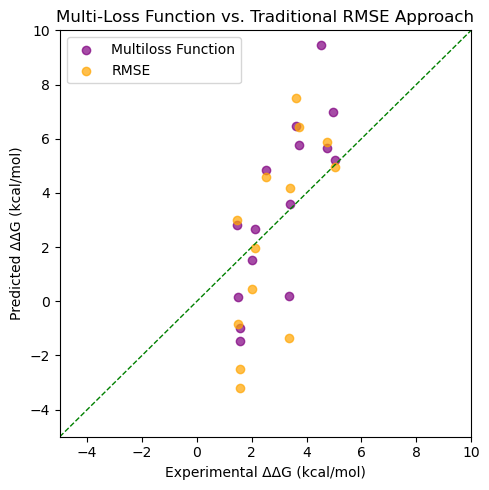

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.title("Multi-Loss Function vs. Traditional RMSE Approach")
plt.scatter(y_test, hybrid_y_pred, alpha=0.7,color="purple", label = "Multiloss Function")
plt.scatter(y_test, y_pred_test_nohyb, alpha=0.7,color="orange", label="RMSE")
plt.xlabel("Experimental ΔΔG (kcal/mol)")
plt.ylabel("Predicted ΔΔG (kcal/mol)")
plt.xlim(-5,10)
plt.ylim(-5, 10)

# Reference y = x line
plt.plot([-5, 10], [-5, 10], color='green', lw=1, linestyle='--')
plt.legend()
plt.tight_layout()
plt.savefig('DDG_Predictions_Multi-Loss_vs_RMSE.png',dpi=100, bbox_inches='tight')
plt.show()

## BFE WITH STRUCTURAL

In [25]:
info = []
for pdb in list(PDBs.keys()):
    info.append(df[df['Ids'] == pdb][['pb_host_VDWAALS', 'pb_guest_VDWAALS', 'pb_complex_VDWAALS', 'gb_host_1-4EEL', 'gb_guest_1-4EEL', 'gb_Complex_1-4EEL',
       'gb_host_EELEC', 'gb_guest_EELEC', 'gb_Complex_EELEC', 'gb_host_EGB', 'gb_guest_EGB', 'gb_Complex_EGB', 'gb_host_ESURF', 'gb_guest_ESURF', 'gb_Complex_ESURF']].to_numpy()[0])


In [26]:
X = []
y = []
for i, pdb in enumerate(list(PDBs.keys())):
    X.append(featurize(PDBs[pdb], info[i]))
    y.append(df[df['Ids'] == pdb]['Ex _G_(kcal/mol)'].to_numpy()[0])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
len(X_train), len(X_test), len(y_train), len(y_test)

(57, 15, 57, 15)

In [28]:
import models.layers_update_mobley as layers
import importlib
importlib.reload(layers)
import keras.backend as K

from tensorflow.keras.callbacks import EarlyStopping

class PGGCN_Structural(tf.keras.Model):
    def __init__(self, num_atom_features=36, r_out_channel=20, c_out_channel=128, l2=1e-4, dropout_rate=0.2, maxnorm=3.0):
        super().__init__()
        self.ruleGraphConvLayer = layers.RuleGraphConvLayer(r_out_channel, num_atom_features, 0)
        self.ruleGraphConvLayer.combination_rules = []
        self.conv = layers.ConvLayer(c_out_channel, r_out_channel)
        self.dense1 = tf.keras.layers.Dense(32, activation='relu', name='dense1', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dense5 = tf.keras.layers.Dense(16, activation='relu', name='dense2', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.dense6 = tf.keras.layers.Dense(1, name='dense6', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dense7 = tf.keras.layers.Dense(1, name='dense7',
                                             kernel_initializer=tf.keras.initializers.Constant([.3, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1]),
                                             bias_initializer=tf.keras.initializers.Zeros(),
                                             kernel_regularizer=regularizers.l2(l2), 
                                             bias_regularizer=regularizers.l2(l2), 
                                             kernel_constraint=constraints.MaxNorm(maxnorm))
        
    def addRule(self, rule, start_index, end_index = None):
        self.ruleGraphConvLayer.addRule(rule, start_index, end_index)
    
    def set_input_shapes(self, i_s):
        self.i_s = i_s

    def call(self, inputs, training=False):
        print("Inside call")
        physics_info = inputs[:, 0, 38:] 
        x_a = []
        for i in range(len(self.i_s)):
            x_a.append(inputs[i][:self.i_s[i], :38])
        x = self.ruleGraphConvLayer(x_a)
        x = self.conv(x)
        x = self.dense1(x)
        x = self.dropout1(x, training=training)
        x = self.dense5(x)
        x = self.dropout2(x, training=training)
        model_var = self.dense6(x)
        merged = tf.concat([model_var, physics_info], axis=1)
        out = self.dense7(merged)
        return out
    
       
class LossComponentsCallback(tf.keras.callbacks.Callback):
    def __init__(self,model_instance):
        super().__init__()
        self.total_losses = []
        self.model = model_instance
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        lr = self.model.optimizer.learning_rate
        self.total_losses.append(logs.get('loss'))

        
def pure_rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


ms= PGGCN_Structural()
ms.addRule("sum", 0, 32)
ms.addRule("multiply", 32, 33)
ms.addRule("distance", 33, 36)



opt = tf.keras.optimizers.Adam(learning_rate=0.005)
ms.compile(loss=pure_rmse, optimizer=opt)


input_shapes = []
for i in range(len(X_train)):
    input_shapes.append(np.array(X_train[i]).shape[0])
ms.set_input_shapes(input_shapes)
for i in range(len(X_train)):
    if X_train[i].shape[0] < 2000:
        new_list = np.zeros([2000 - X_train[i].shape[0], 53])
        X_train[i] = np.concatenate([X_train[i], new_list], 0)
        
X_train_struct = np.array(X_train)
y_train_struct = np.array(y_train)

loss_tracker_struct = LossComponentsCallback(ms)

early_stop = EarlyStopping(
monitor='loss',           
patience=10,              
restore_best_weights=True, 
min_delta=0.001,          
verbose=1                 
)
hist = ms.fit(X_train_struct, y_train_struct, epochs = 250, batch_size=len(X_train_struct), callbacks=[early_stop,loss_tracker_struct])

Epoch 1/250
Inside call
Inside call
1/1 [==============================] - 56s 56s/step - loss: 8.9633
Epoch 2/250
1/1 [==============================] - 1s 690ms/step - loss: 16.3525
Epoch 3/250
1/1 [==============================] - 1s 806ms/step - loss: 7.7388
Epoch 4/250
1/1 [==============================] - 1s 814ms/step - loss: 10.7652
Epoch 5/250
1/1 [==============================] - 1s 800ms/step - loss: 12.1576
Epoch 6/250
1/1 [==============================] - 1s 767ms/step - loss: 7.9867
Epoch 7/250
1/1 [==============================] - 1s 785ms/step - loss: 3.9275
Epoch 8/250
1/1 [==============================] - 1s 751ms/step - loss: 7.6006
Epoch 9/250
1/1 [==============================] - 1s 816ms/step - loss: 7.8268
Epoch 10/250
1/1 [==============================] - 1s 770ms/step - loss: 4.7000
Epoch 11/250
1/1 [==============================] - 1s 818ms/step - loss: 4.0881
Epoch 12/250
1/1 [==============================] - 1s 763ms/step - loss: 6.3213
Epoch 13/25

1/1 [==============================] - 1s 780ms/step - loss: 2.3629
Epoch 102/250
1/1 [==============================] - 1s 822ms/step - loss: 2.3592
Epoch 103/250
1/1 [==============================] - 1s 857ms/step - loss: 2.3551
Epoch 104/250
1/1 [==============================] - 1s 857ms/step - loss: 2.3511
Epoch 105/250
1/1 [==============================] - 1s 816ms/step - loss: 2.3472
Epoch 106/250
1/1 [==============================] - 1s 819ms/step - loss: 2.3431
Epoch 107/250
1/1 [==============================] - 1s 816ms/step - loss: 2.3392
Epoch 108/250
1/1 [==============================] - 1s 793ms/step - loss: 2.3354
Epoch 109/250
1/1 [==============================] - 1s 814ms/step - loss: 2.3314
Epoch 110/250
1/1 [==============================] - 1s 812ms/step - loss: 2.3277
Epoch 111/250
1/1 [==============================] - 1s 778ms/step - loss: 2.3238
Epoch 112/250
1/1 [==============================] - 1s 784ms/step - loss: 2.3200
Epoch 113/250
1/1 [===========

1/1 [==============================] - 1s 837ms/step - loss: 2.0616
Epoch 202/250
1/1 [==============================] - 1s 796ms/step - loss: 2.0598
Epoch 203/250
1/1 [==============================] - 1s 793ms/step - loss: 2.0583
Epoch 204/250
1/1 [==============================] - 1s 793ms/step - loss: 2.0581
Epoch 205/250
1/1 [==============================] - 1s 759ms/step - loss: 2.0605
Epoch 206/250
1/1 [==============================] - 1s 804ms/step - loss: 2.0700
Epoch 207/250
1/1 [==============================] - 1s 805ms/step - loss: 2.0966
Epoch 208/250
1/1 [==============================] - 1s 795ms/step - loss: 2.1578
Epoch 209/250
1/1 [==============================] - 1s 792ms/step - loss: 2.2578
Epoch 210/250
1/1 [==============================] - 1s 797ms/step - loss: 2.3259
Epoch 211/250
1/1 [==============================] - 1s 804ms/step - loss: 2.2743
Epoch 212/250
1/1 [==============================] - 1s 810ms/step - loss: 2.1710
Epoch 213/250
1/1 [===========

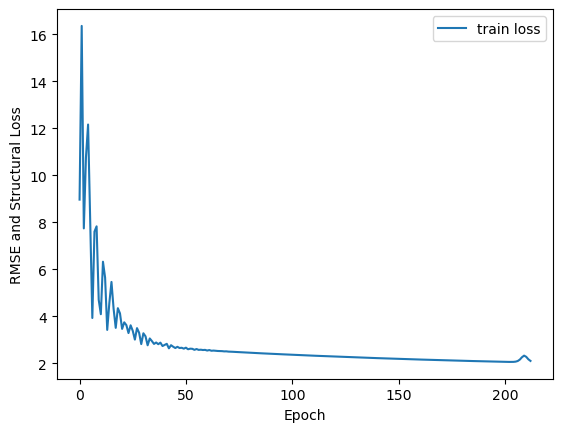

In [29]:
import matplotlib.pyplot as plt

# hist is the History object returned by .fit()
plt.plot(hist.history['loss'], label='train loss')

plt.xlabel('Epoch')
plt.ylabel('RMSE and Structural Loss')
plt.legend()
plt.show()

In [30]:
X_test_struct = X_test
y_test_struct = y_test
input_shapes = []
for i in range(len(X_test_struct)):
    input_shapes.append(np.array(X_test_struct[i]).shape[0])
ms.set_input_shapes(input_shapes)

for i in range(len(X_test_struct)):
    if X_test_struct[i].shape[0] < 2000:
        new_list = np.zeros([2000 - X_test_struct[i].shape[0], 53])
        X_test_struct[i] = np.concatenate([X_test_struct[i], new_list], 0)
X_test_struct = np.array(X_test_struct)
x_c = copy.deepcopy(X_test_struct)
y_test_struct = np.array(y_test_struct)
y_pred_test_struct = ms.predict(X_test_struct) 
y_pred_test_struct = np.array(y_pred_test_struct)

y_difference_struct = np.mean(np.abs(np.abs(y_test_struct) - np.abs(y_pred_test_struct)))
eval_struct = ms.evaluate(X_test_struct, y_test_struct)
print("The mean absolute difference between y_tru & y_pred is : {}" .format(str(y_difference_struct)))


result_temp = {
    'name':'ΔΔG with Structural Loss Function',
    'y_test': y_test_struct,
    'test_loss': eval_struct,
    'y_pred_test': y_pred_test_struct,
    'MAD': y_difference_struct,
    'all_losses': loss_tracker_struct.total_losses,
    'empirical_losses': None,
    'physical_losses': None,
    'hyperparameters': {
                        'physics_weight': None,
                        'epochs': None,
                        'initial_learning_rate': None,
                        'decay_steps': None,
                        'decay_rate': None
    }
}


# Also append to the all_results list for combined saving later
results["structural loss"] = result_temp
all_results.append(result_temp)

Inside call
1/1 [==============================] - 5s 5s/step
Inside call
1/1 [==============================] - 5s 5s/step - loss: 2.2648
The mean absolute difference between y_tru & y_pred is : 2.494689359514448


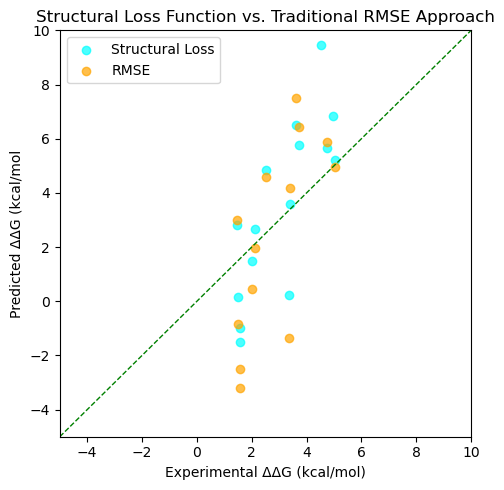

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.title("Structural Loss Function vs. Traditional RMSE Approach")
plt.scatter(y_test, y_pred_test_struct, alpha=0.7,color="cyan", label = "Structural Loss")
plt.scatter(y_test, y_pred_test_nohyb, alpha=0.7,color="orange", label="RMSE")

plt.xlabel("Experimental ΔΔG (kcal/mol)")
plt.ylabel("Predicted ΔΔG (kcal/mol")
plt.xlim(-5,10)
plt.ylim(-5, 10)

# Reference y = x line

plt.plot([-5, 10], [-5, 10], color='green', lw=1, linestyle='--')
plt.legend()
plt.tight_layout()
plt.savefig('Model_Performance_Structural_vs_Traditional_DDG.png',dpi=100, bbox_inches='tight')
plt.show()

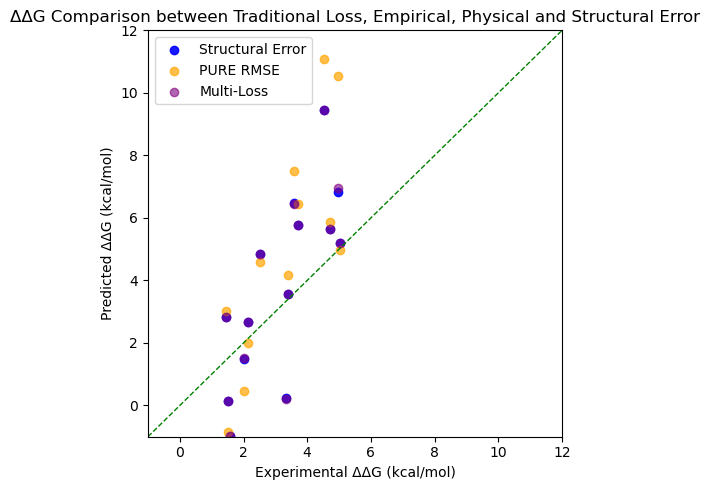

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.title("ΔΔG Comparison between Traditional Loss, Empirical, Physical and Structural Error")
plt.scatter(y_test, y_pred_test_struct, alpha=0.9,color="blue", label = "Structural Error")
plt.scatter(y_test, y_pred_test_nohyb, alpha=0.7,color="orange", label="PURE RMSE")
plt.scatter(y_test, hybrid_y_pred, alpha=0.6,color="purple", label="Multi-Loss")

plt.xlabel("Experimental ΔΔG (kcal/mol)")
plt.ylabel("Predicted ΔΔG (kcal/mol)")
plt.xlim(-1,12)
plt.ylim(-1, 12)

# Reference y = x line
plt.plot([-1, 12], [-1, 12], color='green', lw=1, linestyle='--')

plt.legend()
plt.tight_layout()

plt.savefig('Emp_Struct_Phy_Loss.png', dpi=100, bbox_inches='tight')
plt.show()

In [33]:
# Save individual run results
individual_filename = f'/home/lthoma21/BFE-Loss-Function/FINAL-HOSTGUEST-FILES/Result_Pickle/DDG72_test2_Predictions.pkl'
with open(individual_filename, 'wb') as f:
    pickle.dump(results, f)
print(f"Results saved to {individual_filename}")

Results saved to /home/lthoma21/BFE-Loss-Function/FINAL-HOSTGUEST-FILES/Result_Pickle/DDG72_test2_Predictions.pkl
